<img src="dcic.png">

# Mapping Inequality in Baltimore

## Introduction 

After the 1929 Stock Market Crash, thousands of Americans were in danger of home foreclosure. To address this problem and stabilize the market, The Home Owners Loan Coperation was created under the Rooselvelt Administration to asses credibility of families in order to decide to refinance their homes.

- Redlining is the process 

- In particular Baltimore,

<img src="baltimoremap-min.png" width=400>


Learn more the Mapping Inequality Project [here](https://dsl.richmond.edu/panorama/redlining/#loc=4/36.71/-96.93&opacity=0.8)

- This data set
- Learning Objectives 

## 1. Aquiring Data

Every form contains the characteristics of a particular section indicated by the security grade map. The fields of each form was transcribed and stored in a json format and converted into a csv.

A data frame is a table where every row represents a single unique object and every column represents characteristics of these objects. We can use the pandas library to read our comma seperated file (csv) and create a data frame to prepare the data for analysis.

### Importing the Data and Creating a Data Frame

In [289]:
# Loads the Pandas library 
import pandas as pd

# Creates data frame named df by reading in the Baltimore csv
df = pd.read_csv("AD_Data_BaltimoreProject.csv")
df.head(n=3)

,Form,State,City,Security_Grade,Area_Number,Terrain_Description,Favorable_Influences,Detrimental_Influences,INHABITANTS_Type,INHABITANTS_Annual_Income,...,INHABITANTS_Population_Increase,INHABITANTS_Population_Decrease,INHABITANTS_Population_Static,BUILDINGS_Types,BUILDINGS_Construction,BUILDINGS_Age,BUILDINGS_Repair,Ten_Fifteen_Desirability,Remarks,Date
0,NS FORM-8 6-1-37,Maryland,Baltimore,A,2,Rolling,Fairly new suburban area of homogeneous charac...,None,Substantial Middle Class,"$3000 - 5,000",...,Fast,NaN,NaN,Detached an row houses,Brick and frame,1 to 10 years,Good,Upward,A recent development with much room for expans...,"May 4,1937"
1,NS FORM-8 6-1-37,Maryland,Baltimore,A,1,Undulating,Very nicely planned residential area of medium...,None,"Executives, Professional Men",over $5000,...,Moderately Fast,NaN,NaN,Single family detached,Brick and Stone,12 years,Very good,Upward,Mostly fee properties. A few homes valued at $...,"May 4,1937"
2,NS FORM-8 6-1-37,Maryland,Baltimore,A,3,Rolling,Good residential area. Well planned.,Distance to City,"Executives, Professional Men",3500 - 7000,...,Moderately Fast,NaN,NaN,One family detached,"Brick, Stone, and Frame",1 to 20 years,Good to excellent,Upward,Principally fee property. This section lies in...,"May 4,1937"


<img src="Baltimore_AD_002.png" width=400 >

In Baltimore data frame, every row is a unique form, called an observation, and column represents a transcribed field from the form, called a variable. For example, in this form `SECUIRITY GRADE` has value A and `AREA NO.` has value 2. This form can be located in the first row with index 0 in the data frame above. 

## 2. Data Cleaning

After obtaining our data, we need to clean, manipulate, and transform it for analysis and ease of use. This is called data wrangling.

### Handling Similar Text Values 

The `INHABITANTS_Foreignborn` varaible indicates whether there are foreigners in a region. Observe that different forms used 'No' or 'None' to indicate there are no foreigners, NaN indicates the value in the form is missing, and 'Small','Very few', and 'Mixture' are various ways of indicating there were foreigners. 

In [290]:
# Selects rows with indeces between 0 to 15 included of the 'INHABITANTS_Foreignborn' column
df.ix[0:15,'INHABITANTS_Foreignborn']

0           No
1         None
2         None
3         None
4         None
5          NaN
6           No
7           No
8           No
9        Small
10    Very few
11          No
12          No
13          No
14          No
15     Mixture
Name: INHABITANTS_Foreignborn, dtype: object

Since columns with standardized values are easier to analyze, we are going to transform this column to indicate whether there are foreigners or not. In Python, 'None' is a special keyword that indicates the cell has a null value. Therefore, we will alter all the 'None' values to 'No' and every other value that indicates there are to 'Yes'.

In [291]:
# Replaces the values of 'None' with 'No'
df['INHABITANTS_Foreignborn'] = df['INHABITANTS_Foreignborn'].replace('None', 'No')

# Replaces all other values with 'Yes'
for value in df['INHABITANTS_Foreignborn']:
    if value != 'No' and value != 'NaN':
        df['INHABITANTS_Foreignborn'] = df['INHABITANTS_Foreignborn'].replace(value, 'Yes')

df.ix[0:15,'INHABITANTS_Foreignborn']

0      No
1      No
2      No
3      No
4      No
5     Yes
6      No
7      No
8      No
9     Yes
10    Yes
11     No
12     No
13     No
14     No
15    Yes
Name: INHABITANTS_Foreignborn, dtype: object

Detrimental_Influences - 

Notice in this case that there are multiple variations of the meaning of 'No' to be replaced. 

In [292]:
df.ix[0:15,'Detrimental_Influences']

0                                          None
1                                          None
2                              Distance to City
3                                          None
4                                          None
5                                           NaN
6                                           No.
7                                          None
8     Few streets of property in poor condition
9                                          None
10                                         None
11                      Built on filled ground.
12                                         None
13                                         None
14                   Distance to center of city
15                                         None
Name: Detrimental_Influences, dtype: object

To handle the multiple words to be replaced we can use an array to store a string of values.

In [293]:
no_words = ['No.','no', 'none', 'None']

for word in no_words:
    df['Detrimental_Influences'] = df['Detrimental_Influences'].replace( word , 'No')

We need to do these same operations for `INHABITANTS_Negro` and `INHABITANTS_Infiltration`. Functions
paramters, arguments

In [294]:
def replace_values(attribute, new_word, words_to_replace):
    for word in words_to_replace:
        df[attribute] = df[attribute].replace(word, new_word) 


replace_values('INHABITANTS_Negro', 'No', no_words)
replace_values('INHABITANTS_Infiltration', 'No', no_words)

In [295]:
df.ix[0:15,'INHABITANTS_Infiltration']

0                  No
1                  No
2                  No
3                  No
4                  No
5                 NaN
6                  No
7                  No
8                  No
9                 NaN
10                 No
11                 No
12                 No
13                 No
14                 No
15    People from C-1
Name: INHABITANTS_Infiltration, dtype: object

In [296]:
# Various words meaning small 
small_words = ['Nominal','nominal', 'Small','small','Minimum', 'minimum','minimal', 'Very few']

replace_values('INHABITANTS_Negro', 'Few', small_words)
replace_values('INHABITANTS_Infiltration', 'Few', small_words)

We can clean up the values of `INHABITANTS_Population_Increase` by choosing standard c

In [297]:
 df.ix[0:15,'INHABITANTS_Population_Increase']

0               Fast 
1     Moderately Fast
2     Moderately Fast
3              Slowly
4     Moderately Fast
5                 NaN
6                 NaN
7              Slowly
8     Moderately Fast
9     Moderately Fast
10                NaN
11             Slowly
12             Slowly
13         Moderately
14             Slowly
15              Fast 
Name: INHABITANTS_Population_Increase, dtype: object

In [298]:
# Will define degrees of speed as very slowly, slowly, moderately, moderately fast, fast

# Defines values to replace in the table 
very_slowly = ['Very Slowly', 'very slowly', 'very Slowly']
slowly = ['slowly', 'fairly slowly']
moderately = ['moderately']
moderately_fast = ['Moderately Fast', 'moderately Fast', 'moderately fast']
fast = ['very fast', 'Very Fast', 'fast']

# Applies function to obtain our new values 
replace_values('INHABITANTS_Population_Increase', 'Very slowly', very_slowly)
replace_values('INHABITANTS_Population_Increase', 'Slowly', slowly)
replace_values('INHABITANTS_Population_Increase', 'Moderately', moderately )
replace_values('INHABITANTS_Population_Increase', 'Moderately fast', moderately_fast)
replace_values('INHABITANTS_Population_Increase', 'Moderately fast', moderately_fast)
replace_values('INHABITANTS_Population_Increase', 'Fast', fast)


In [299]:
 df.ix[0:15,'INHABITANTS_Population_Increase']

0               Fast 
1     Moderately fast
2     Moderately fast
3              Slowly
4     Moderately fast
5                 NaN
6                 NaN
7              Slowly
8     Moderately fast
9     Moderately fast
10                NaN
11             Slowly
12             Slowly
13         Moderately
14             Slowly
15              Fast 
Name: INHABITANTS_Population_Increase, dtype: object

### String Parsing to Extract Data

Some of the cities have corresponding suburbs followed by a dash. We can extract the suburbs and create a new column using  `str.split()`.

In [300]:
df.ix[16:30,'City']

16                                Baltimore 
17                       Baltimore - Dundalk
18                                 Baltimore
19                  Baltimore - Metropolitan
20                                 Baltimore
21                  Baltimore - Metropolitan
22                                 Baltimore
23                   Baltimore - Sub. Burton
24    Baltimore - Sub. Mt. Washington Summit
25                Baltimore - Sub. Villahove
26            Baltimore - Sub. Colonial Park
27        Baltimore - Sub. Linthicum Heights
28                                 Baltimore
29                                 Baltimore
30                                 Baltimore
Name: City, dtype: object

In [301]:
# Creates a new data frame that splits the values in the orginal data frame on the '-' character 
newdf = df["City"].str.split('-', n = 1, expand = True) 
newdf.head()

# Creates two new columns 
df['City_clean'] = newdf[0]
df['Suburb'] = newdf[1]

# removes the old column
df.drop(["City"], axis = 1, inplace = True) 

# renames as 'City'
df.rename(index=str, columns={"City_clean": "City"});

In [302]:
df.ix[16:30,['Suburb']]

,Suburb
16,None
17,Dundalk
18,None
19,Metropolitan
20,None
21,Metropolitan
22,None
23,Sub. Burton
24,Sub. Mt. Washington Summit
25,Sub. Villahove


The `BUILDINGS_Age` attribute represents the range of the age of the buildings in a region. Notice the range is given is given as a string of text. For purpose of analysis, we would like to extract the upper end of the range and create a column of numeric values.

In [303]:
df.ix[0:15,'BUILDINGS_Age']

0      1 to 10 years
1           12 years
2      1 to 20 years
3           10 years
4      1 to 20 years
5                NaN
6           25 years
7     15 to 25 years
8           15 years
9      5 to 25 years
10          20 years
11     5 to 10 years
12          10 years
13          25 years
14     1 to 20 years
15     6 to 25 years
Name: BUILDINGS_Age, dtype: object

Observe that the number to extract is always the last number ..

In [304]:
df['max_building_age'] = df['BUILDINGS_Age'].str.extract('(\d+)(?!.*\d)', expand=True)

In [305]:
df.ix[0:15,['BUILDINGS_Age','max_building_age']]

,BUILDINGS_Age,max_building_age
0,1 to 10 years,10
1,12 years,12
2,1 to 20 years,20
3,10 years,10
4,1 to 20 years,20
5,NaN,NaN
6,25 years,25
7,15 to 25 years,25
8,15 years,15
9,5 to 25 years,25


### Handling Dates 

 The `Date` column has three attributes given by **month day, year**.

In [359]:
df.ix[0:3,['Date']]

,Date
0,"May 4,1937"
1,"May 4,1937"
2,"May 4,1937"
3,"May 4,1937"


We can seperate this column into three columns:  `Month`, `Day`, and `Year` using `str.extract()` and regular expressions.

In [358]:
# extracts the year using regular expression (\d\d\d\d) to indicate 4 digit date
df['Year'] = df['Date'].str.extract('(\d\d\d\d)', expand=True)

# extracts day using regular expression \d to indicate single digit
df['Day'] = df['Date'].str.extract('(\d)', expand=True)

# extracts month using regular expression [A-Z]\w{0,} to indicate string of characters
df['Month'] = df['Date'].str.extract('([A-Z]\w{0,})', expand=True)

df.ix[0:3,['Date','Month','Day','Year']]

,Date,Month,Day,Year
0,"May 4,1937",May,4,1937
1,"May 4,1937",May,4,1937
2,"May 4,1937",May,4,1937
3,"May 4,1937",May,4,1937


In [308]:
# original
df.ix[0:7,['INHABITANTS_Annual_Income']]

,INHABITANTS_Annual_Income
0,"$3000 - 5,000"
1,over $5000
2,3500 - 7000
3,over $5000
4,"$3,500 - $10,000"
5,NaN
6,over $4000
7,over $5000


In [309]:
# removes anything that is not a digit or ,
df['max_annual_income'] = df['INHABITANTS_Annual_Income'].str.replace('[^\d(,)]',' ')

In [310]:
df.ix[0:7,['max_annual_income']]

,max_annual_income
0,"3000 5,000"
1,5000
2,3500 7000
3,5000
4,"3,500 10,000"
5,NaN
6,4000
7,5000


In [311]:
# removes delimeter 
df['max_annual_income'] = df['max_annual_income'].str.replace('[(,)]','')

In [312]:
df.ix[0:7,['max_annual_income']]

,max_annual_income
0,3000 5000
1,5000
2,3500 7000
3,5000
4,3500 10000
5,NaN
6,4000
7,5000


In [313]:
# extracts the second number 
df['max_annual_income'] = df['max_annual_income'].str.extract('(\d+)(?!.*\d)', expand=True)

In [314]:
df.ix[0:7,['max_annual_income']]

,max_annual_income
0,5000
1,5000
2,7000
3,5000
4,10000
5,NaN
6,4000
7,5000


## 3. Data Manipulation 

### Encoding Categorical Data

In [315]:
 df.ix[0:15,'INHABITANTS_Population_Increase']

0               Fast 
1     Moderately fast
2     Moderately fast
3              Slowly
4     Moderately fast
5                 NaN
6                 NaN
7              Slowly
8     Moderately fast
9     Moderately fast
10                NaN
11             Slowly
12             Slowly
13         Moderately
14             Slowly
15              Fast 
Name: INHABITANTS_Population_Increase, dtype: object

### Sorting and Grouping 

In [354]:
df['Security_Grade'] = df['Security_Grade'].str.replace('[\W]','')
df['Area_Number'] = pd.to_numeric(df['Area_Number'])
df.ix[0:10,['Security_Grade','Area_Number']]

,Security_Grade,Area_Number
0,A,2
1,A,1
2,A,3
3,A,4
4,A,5
5,A,6
6,B,1
7,B,2
8,B,3
9,B,4


In [357]:
sort_by_area_number = df.sort_values(['Security_Grade', 'Area_Number'])
sort_by_area_number.ix[1:10,['Security_Grade','Area_Number']]

,Security_Grade,Area_Number
1,A,1
0,A,2
2,A,3
3,A,4
4,A,5
5,A,6
6,B,1
7,B,2
8,B,3
9,B,4


## 4. Exploratory Data Analysis and Visualization

Exploratory data analysis 

In [320]:
df['max_building_age'].describe()

count     46
unique    12
top       25
freq       9
Name: max_building_age, dtype: object

In [321]:
# converts max_building age to numeric type
df["max_building_age"] = pd.to_numeric(df["max_building_age"])
df['max_building_age'].describe()

count    46.000000
mean     30.086957
std      16.497577
min      10.000000
25%      20.000000
50%      25.000000
75%      40.000000
max      65.000000
Name: max_building_age, dtype: float64

In [322]:
df['max_annual_income'].describe()

count       46
unique      12
top       2500
freq         8
Name: max_annual_income, dtype: object

In [323]:
df['max_annual_income'] = pd.to_numeric(df['max_annual_income'])
df['max_annual_income'].describe()

count       46.000000
mean      3139.130435
std       2009.806874
min       1000.000000
25%       1850.000000
50%       2750.000000
75%       4000.000000
max      10000.000000
Name: max_annual_income, dtype: float64

In [324]:
import matplotlib.pyplot as plt

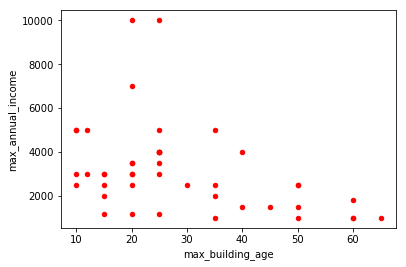

In [325]:
df.plot(kind='scatter',x='max_building_age',y='max_annual_income',color='red')
plt.show()

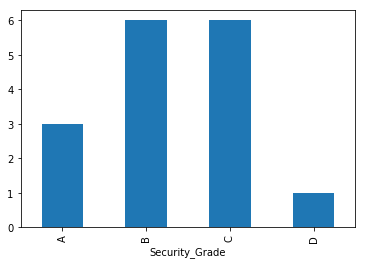

In [339]:
df.groupby('Security_Grade')['max_annual_income'].nunique().plot(kind='bar')
plt.show()

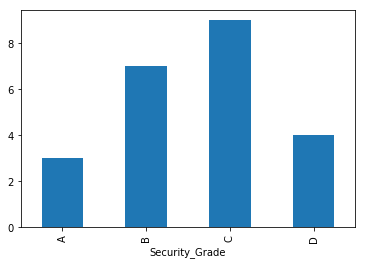

In [340]:
df.groupby('Security_Grade')['max_building_age'].nunique().plot(kind='bar')
plt.show()

<img src="redl.png">